In [1]:
## Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from imblearn.under_sampling import RandomUnderSampler as RUS
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LogisticRegression as LR
from xgboost import XGBClassifier as XGBC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset and display the overview of first five rows

dat  = pd.read_excel('PSP_Jan_Feb_2019.xlsx')  # This read out the dataset
dat.head()  # Display first 5 rows of the loaded dataset for quick observation

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [3]:
# Check the number of missing values in the datasets

dat.isna().sum()  # Add the count of possible missing values in each feature or column

Unnamed: 0    0
tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

In [4]:
# Explore the descriptive statistics summary of the given data

dat.describe().T  # Reveal the basic descriptive statistics in the transpose form 

,count,mean,min,25%,50%,75%,max,std
Unnamed: 0,50410.0,25204.5,0.0,12602.25,25204.5,37806.75,50409.0,14552.257872
tmsp,50410,2019-01-29 16:28:52.923269120,2019-01-01 00:01:11,2019-01-14 12:00:36.249999872,2019-01-30 15:20:07.500000,2019-02-13 01:09:50.500000,2019-02-28 23:48:19,NaN
amount,50410.0,202.395715,6.0,133.0,201.0,269.0,630.0,96.27473
success,50410.0,0.202896,0.0,0.0,0.0,0.0,1.0,0.40216
3D_secured,50410.0,0.238266,0.0,0.0,0.0,0.0,1.0,0.426027


In [5]:
# Data types and Other properpties of the datasets

dat.info() # Reveal the information partain to the given data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   success     50410 non-null  int64         
 5   PSP         50410 non-null  object        
 6   3D_secured  50410 non-null  int64         
 7   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 3.1+ MB


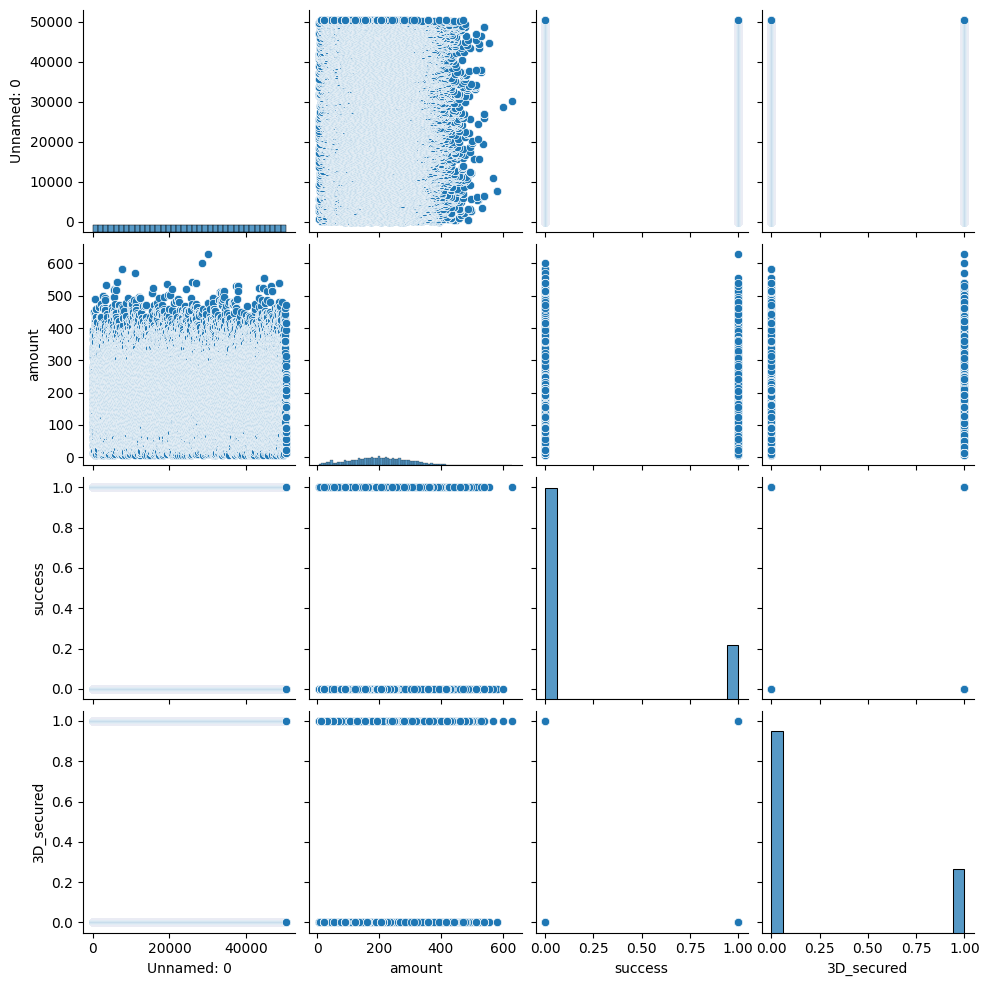

In [6]:
# Display the pairwise relationship between numeric features of the given datasets

sb.pairplot(dat) # perform a pairwise plot of the features
plt.show() # Show the relationship

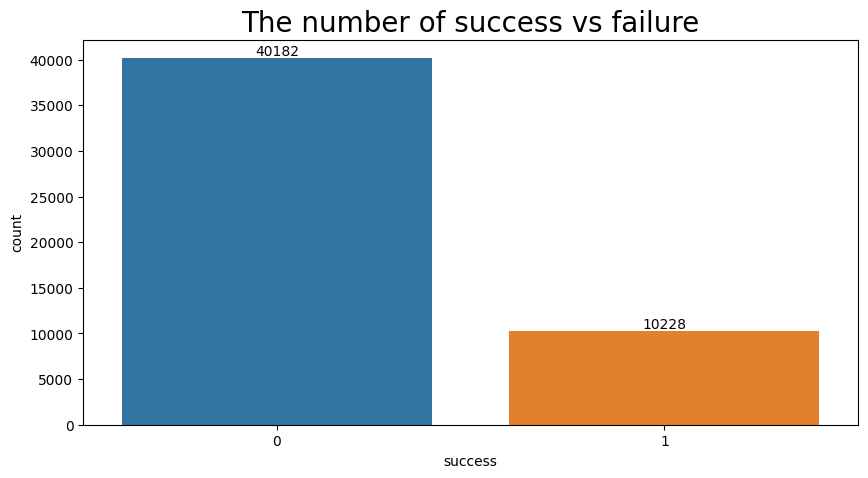

In [7]:
# Explore if there is imbalance in the target variable class.
# This will avoid posibilities of learning model for the model  algorithms

plt.figure(figsize=(10, 5))
count = sb.countplot(data=dat, x = 'success')
plt.title('The number of success vs failure', size = 20)

# Loop function to label the count on the bar chart

for i in count.containers:  # This loops on the counted numbers, stored in the contatiners for each class
    count.bar_label(i)  # Uphold and display the counted numbers on the bar chart as a data label

In [8]:
# Feature engineering from the given datasets

# Scaling of the timestamp feature

new_dat = pd.DataFrame({'day': dat['tmsp'].dt.day, 'dayoftheweek': dat['tmsp'].dt.dayofweek, 'minute':dat['tmsp'].dt.minute,
                       })
new_dat.head()  # This displays first 5 rows of the newly generated features from the timestamp feature

,day,dayoftheweek,minute
0,1,1,1
1,1,1,1
2,1,1,2
3,1,1,3
4,1,1,4


In [9]:
# Concatenating the given data and the features generated from timestamp feature

upd_dat = pd.concat([dat, new_dat], axis = 1)  # This code line join both datasets by column
upd_dat.head()  # This displays first 5 rows of the concatenated datasets

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card,day,dayoftheweek,minute
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,1,1,1
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,1,1,1
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,1,1,2
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,1,1,3
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,1,4


In [10]:
# Integrate additional information into the data part A

conditn = [
    (upd_dat['PSP'] == 'UK_Card') & (upd_dat['success']== 1),  # Sub-condition number 1
    (upd_dat['PSP'] == 'UK_Card') & (upd_dat['success']== 0),  # Sub-condition number 2
    (upd_dat['PSP'] == 'Moneycard') & (upd_dat['success']== 1),  # Sub-condition number 3
    (upd_dat['PSP'] == 'Moneycard') & (upd_dat['success']== 0),  # Sub-condition number 4
    (upd_dat['PSP'] == 'Goldcard') & (upd_dat['success']== 1),  # Sub-condition number 5
    (upd_dat['PSP'] == 'Goldcard') & (upd_dat['success']== 0),  # Sub-condition number 6
    (upd_dat['PSP'] == 'Simplecard') & (upd_dat['success']== 1),  # Sub-condition number 7
    (upd_dat['PSP'] == 'Simplecard') & (upd_dat['success']== 0)  # Sub-condition number 8
    ]
val = [3, 1, 5, 2, 10, 5, 1, 0.5]  # Values to be selected with each sub-condition respectively
upd_dat['Transaction_fee'] = np.select(conditn, val)  # Create a feature 'Transaction _fee' in the upd_dat using the condition and values 

In [11]:
# Integrate additional information into the data part B

conditn1 = upd_dat.duplicated(subset=['success', 'minute', 'amount', 'country'], keep='first')  # Condition for duplicate transaction trials
upd_dat['duplicated_transaction']= conditn1  # Fill-in the boolean value of the condition into the feature 'Duplicated_transaction'
upd_dat.tail(10)  # This displays first 5 rows of the Updated datasets

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card,day,dayoftheweek,minute,Transaction_fee,duplicated_transaction
50400,50400,2019-02-28 23:34:46,Austria,123,0,UK_Card,0,Visa,28,3,34,1.0,True
50401,50401,2019-02-28 23:35:07,Austria,123,1,UK_Card,0,Visa,28,3,35,3.0,False
50402,50402,2019-02-28 23:36:08,Switzerland,242,1,UK_Card,1,Diners,28,3,36,3.0,False
50403,50403,2019-02-28 23:43:36,Switzerland,208,0,Simplecard,0,Master,28,3,43,0.5,False
50404,50404,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa,28,3,45,1.0,True
50405,50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa,28,3,45,1.0,True
50406,50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master,28,3,46,1.0,False
50407,50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master,28,3,47,1.0,False
50408,50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master,28,3,47,1.0,True
50409,50409,2019-02-28 23:48:19,Austria,91,1,Moneycard,0,Master,28,3,48,5.0,False


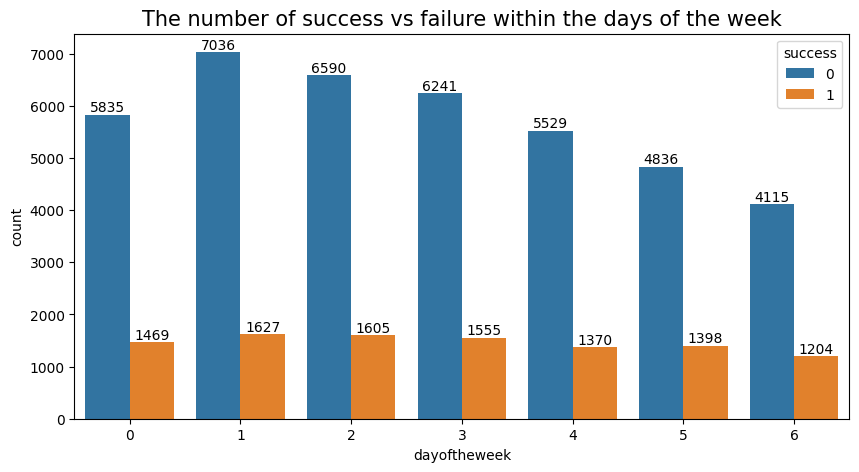

In [12]:
# Explore if either week days or weekend has discrepancy in the success of the payment transaction

plt.figure(figsize=(10, 5))  # Chosen size of the plot

# Plot the count of the transaction (both failed and succ)in the week day

count = sb.countplot(data=upd_dat, x = 'dayoftheweek', hue = 'success')
plt.title('The number of success vs failure within the days of the week', size = 15)

# Loop function to label the count on the bar chart

for i in count.containers:  # This loops on the counted numbers, stored in the contatiners for each class
    count.bar_label(i)  # Uphold and display the counted numbers on the bar chart as a data label

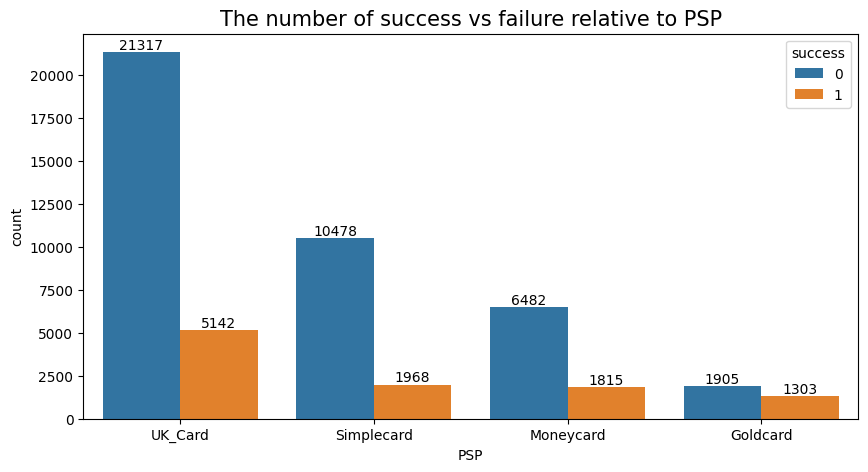

In [13]:
# Dispaly the payment service provider based of the posible failure and success

plt.figure(figsize=(10, 5))

count = sb.countplot(data=upd_dat, x= 'PSP', hue = 'success')
plt.title('The number of success vs failure relative to PSP', size = 15)  # Label the bar chart

# Loop function to label the count on the bar chart

for i in count.containers:  # This loops on the counted numbers, stored in the contatiners for each class
    count.bar_label(i)  # Uphold and display the counted numbers on the bar chart as a data label

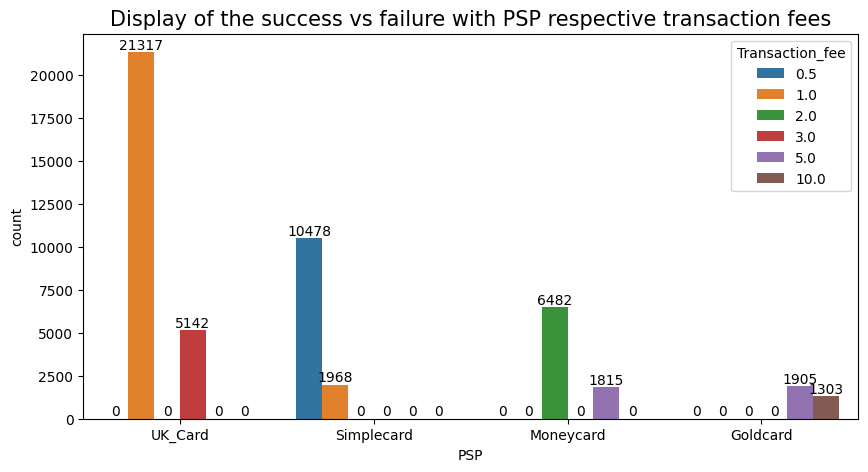

In [14]:
# Dispaly the payment service provider based of the posible failure and success

plt.figure(figsize=(10, 5))

count = sb.countplot(data=upd_dat, x= 'PSP', hue = 'Transaction_fee')
plt.title('Display of the success vs failure with PSP respective transaction fees', size = 15)  # Label the bar chart

# Loop function to label the count on the bar chart

for i in count.containers:  # This loops on the counted numbers, stored in the contatiners for each class
    count.bar_label(i)  # Uphold and display the counted numbers on the bar chart as a data label

In [15]:
# Feature enginerring continues
# Generate hot encoding for the categorical variables

dat_upd = pd.get_dummies(upd_dat, columns = ['country', 'PSP', 'card'], dtype = "int" )  # Changing these feature's values to 0 & 1
dat_upd.replace({True:1, False:0}, inplace=True)  # Replace boolean value with 1 for True and 0 for False
dat_upd.shape  # Display the shape of the data frame (table)

(50410, 20)

In [16]:
# REmove the feature Unnamed: 0 and tmsp
# Unnamed: 0  has no significance other than duplicating the index
# tmsp has be engineered to generate other features

dat_upda = dat_upd.drop(['Unnamed: 0','tmsp'], axis = 1)
dat_upda.shape

(50410, 18)

<Axes: >

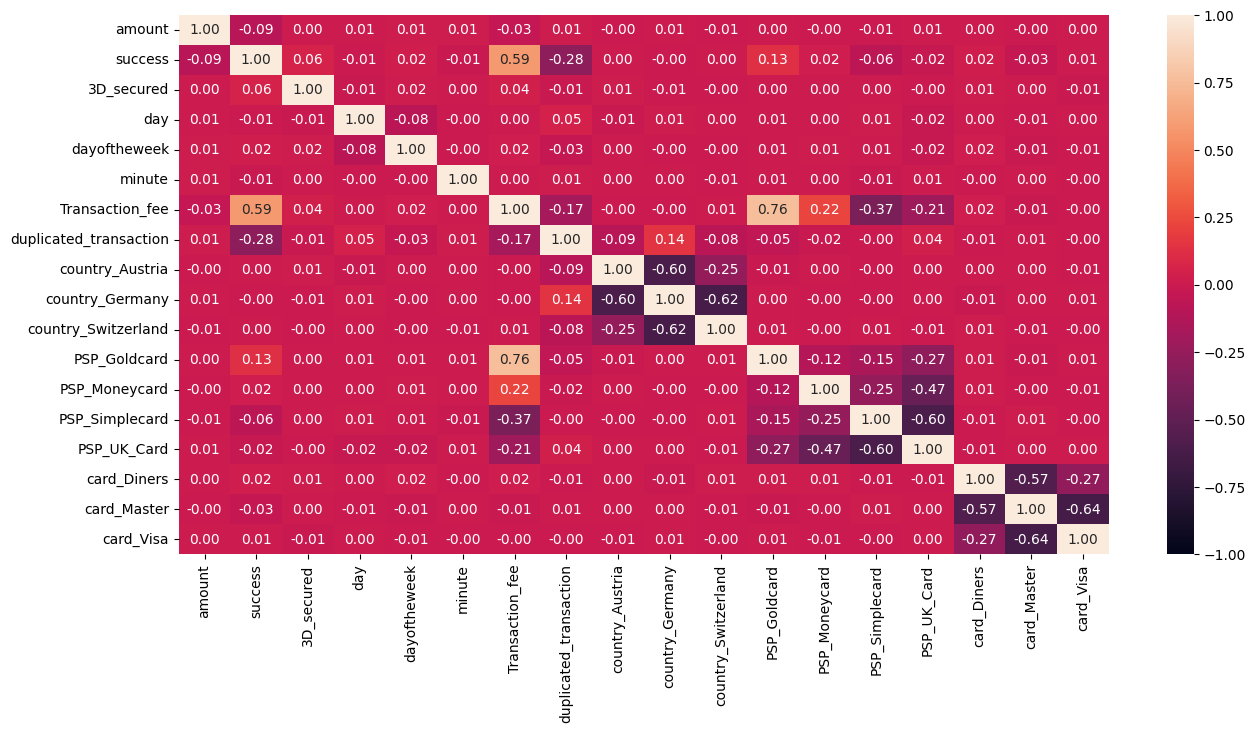

In [17]:
# Check for the correlation of the correlation
plt.figure(figsize=(15, 7))
sb.heatmap(dat_upda.loc[:, :].corr(), vmin = -1, vmax= 1, annot =True, fmt='.2f')

In [18]:
# Separate the dependent (target) and the independent variables

y = dat_upda['success']  # This is the target variable
ind_var = dat_upda.drop('success', axis=1)  # This are the independent variables
x = ind_var

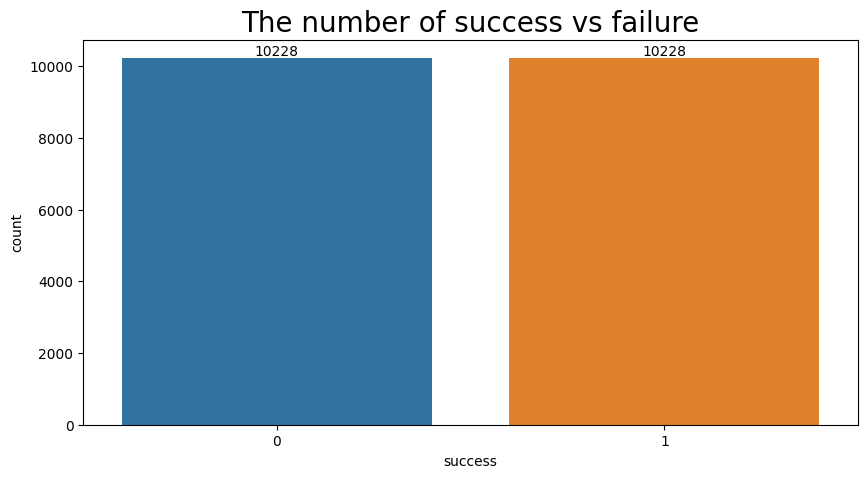

In [19]:
# The target variable is 'success' with 2 imbalance classes as visualized above
# The code section below explicitly details the under-sampling tecqniques using imblearn library
# This is necessary to avoid learning bias for the possible algorithms for the modelling

rand_und_samp = RUS(random_state=42, replacement=True)
x_rand_und_samp, y_rand_und_samp = rand_und_samp.fit_resample(x, y)  # model the random sampling to balance counts

# Visualizing the target variable now to affirm if the two classes (0, 1)are balance now

bal_dat = pd.concat([x_rand_und_samp, y_rand_und_samp], axis = 1)  # This code line join both datasets by column

# Explore if there is imbalance in the target variable class.
# This will avoid posibilities of the learning model bias 

# for the model  algorithms

plt.figure(figsize=(10, 5))
count = sb.countplot(data=bal_dat, x = 'success')
plt.title('The number of success vs failure', size = 20)

# Loop function to label the count on the bar chart

for i in count.containers:  # This loops on the counted numbers, stored in the contatiners for each class
    count.bar_label(i)  # Uphold and display the counted numbers on the bar chart as a data label

<Axes: >

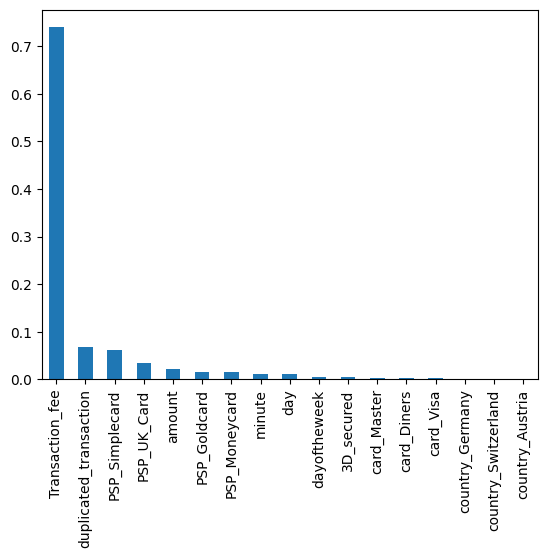

In [20]:
# Feature Selection of important features for the modelling
# Having check the corrrelation above, some features are seemling not promising
# Model based feauture selection will be performed using random forest

# Split dataset to train and test dataset
x_train, x_test, y_train, y_test = train_test_split(x_rand_und_samp, y_rand_und_samp, test_size = 0.2) 

# Model with random forest algorithm
RFC_model = RFC(n_estimators = 1000)  
RFC_model.fit(x_train, y_train)
y_predict = RFC_model.predict(x_test)

# Plot the significance probability of each feature
feat_impt = pd.Series(RFC_model.feature_importances_, index=x_train.columns).sort_values(ascending= False)
feat_impt.plot(kind='bar')

In [21]:
# The chosen fetures for the models based on feature importances are:
# Transaction_fee, duplicated_transaction, PSP_Simplecard, PSP_UK_Card, amount, PSP_Goldcard, PSP_Moneycard, minute, and day
# I will delete less impotant features in the datasets for the modelling

model_xRUS = x_rand_und_samp.drop(columns = ['dayoftheweek', '3D_secured', 'card_Master', 'card_Diners', 
                           'card_Visa','country_Germany', 'country_Switzerland', 'country_Austria']
                )  # This are the selected features as the independent variables for the model

model_xRUS.shape  # Checking the shape of random under sampling samples for the modelling

(20456, 9)

In [22]:
# Baseline model: Multiple logistic regression is selected as detailed below

x_train1, x_test1, y_train1, y_test1 = train_test_split(model_xRUS, y_rand_und_samp, test_size = 0.2)

# Model with logistic regression algorithm
base_model = LR()  
base_model.fit(x_train1, y_train1)

y_predict1 = base_model.predict(x_test1)  #  Predict the outcome variable from the test dataset

# Define function for the evaluation statistics
def metric_statistics(y_test1, y_predict1):
    print('Accuracy: ', metrics.accuracy_score(y_test1, y_predict1))
    print('Precision: ', metrics.precision_score(y_test1, y_predict1))
    print('Recall: ', metrics.recall_score(y_test1, y_predict1))
          
metric_statistics(y_test1, y_predict1)  # Call the defined function to print the evaluation statistics

Accuracy:  1.0
Precision:  1.0
Recall:  1.0


In [23]:
# Other machine learning algorithm to be used for modelling and compare the performance with the baseline model
# Number 1: Random  forest algorithm

# Model with Random forest algorithm
RFC_model1 = RFC(n_estimators = 1000)
RFC_model1.fit(x_train1, y_train1)

y_predict2 = RFC_model1.predict(x_test1)  #  Predict the outcome variable from the test dataset


# Define function for the evaluation statistics
def metric_statistics(y_test1, y_predict2):
    print('Accuracy: ', metrics.accuracy_score(y_test1, y_predict2))
    print('Precision: ', metrics.precision_score(y_test1, y_predict2))
    print('Recall: ', metrics.recall_score(y_test1, y_predict2))
          
metric_statistics(y_test1, y_predict2)  # Call the defined function to print the evaluation statistics

Accuracy:  1.0
Precision:  1.0
Recall:  1.0


In [24]:
# Number 2: XGBoost

# Model with xgboost algorithm
XGBC_model = XGBC()
XGBC_model.fit(x_train1, y_train1)

y_predict3 = XGBC_model.predict(x_test1)  #  Predict the outcome variable from the test dataset

# Define function for the evaluation statistics
def metric_statistics(y_test1, y_predict3):
    print('Accuracy: ', metrics.accuracy_score(y_test1, y_predict3))
    print('Precision: ', metrics.precision_score(y_test1, y_predict3))
    print('Recall: ', metrics.recall_score(y_test1, y_predict3))
          
metric_statistics(y_test1, y_predict3)  # Call the defined function to print the evaluation statistics

Accuracy:  1.0
Precision:  1.0
Recall:  1.0


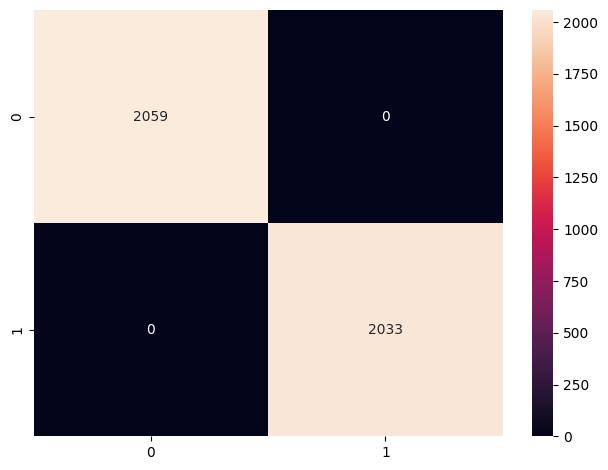

In [25]:
# Visualized the confusion matrix
# The random forest and XGBoost algorithm has the same absolute performance with the baseline model
# Thus one confusion matrix (baseline model) will be displayed

confux_mat = metrics.confusion_matrix(y_test1, y_predict1)  # 

# Dispay the confusion matrix 
fig, ax = plt.subplots()
sb.heatmap(confux_mat, annot = True, fmt = 'g')

plt.tight_layout()

In [26]:
# Above is the code for predicting the card routing for the online purchase